In [1]:
import math
import sys
sys.path.append('../darknight/')
from fcts import array_in_nd_array, remove_space, r2pcorr,struc2mol
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools,Draw
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
#import package
from sklearn import linear_model
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [2]:
#load model
model = darkchem.utils.load_model('../Final Trained DarkChem Network Weights/N7b_[M+H]')

In [3]:
data = pd.read_csv('multiple_0.9_classify.csv')

In [4]:
# calculate the vectors of reactants and products
rvec = [darkchem.utils.struct2vec(reactant) for reactant in data['Reactants']]
pvec = [darkchem.utils.struct2vec(product) for product in data['Products']]
# transform the data type to np.array 
# for the calculation of latent space vectors
rvec = np.array(rvec).astype(int)
pvec = np.array(pvec).astype(int)

In [5]:
#generate the latent space representation for reactants and products
r_latent = model.encoder.predict(rvec)
p_latent = model.encoder.predict(pvec)

In [6]:
# transform the data type to DataFrame for the computing of Pearson Correlation
rvecdf = pd.DataFrame(r_latent)
pvecdf = pd.DataFrame(p_latent)

In [7]:
# calculate the correlation between the latent reactant vectors to product vectors
r2p = r2pcorr(rvecdf,pvecdf)
#r2p

In [8]:
# the average value of correlation
r2p.mean()

Correlation    0.942535
dtype: float64

In [9]:
#load regression analysis set
x = rvecdf.iloc[:,0:128].values
y = pvecdf.iloc[:,0:128].values

In [10]:
# split the training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = .2, random_state=1)  #random_state = 1

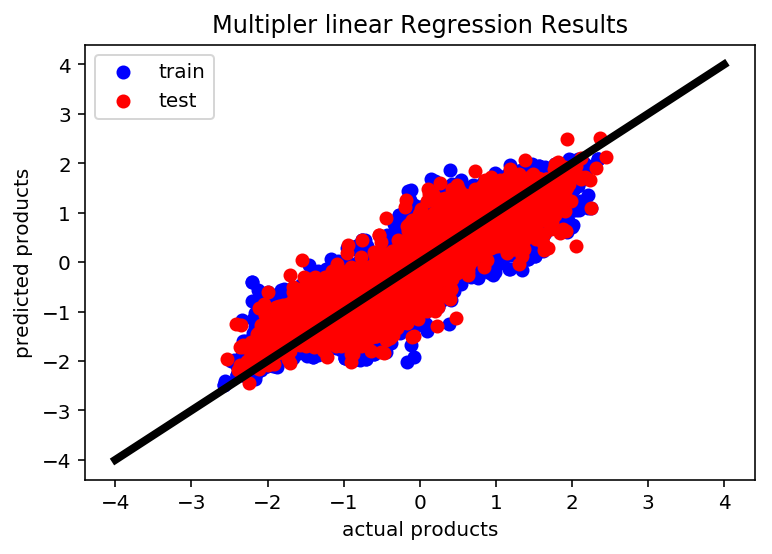

In [11]:
MLR = linear_model.LinearRegression()
MLR.fit(X_train,Y_train)
testpred = MLR.predict(X_test)
trainpred = MLR.predict(X_train)
plt.scatter(Y_train,trainpred,color='blue',label = 'train')
plt.scatter(Y_test,testpred,color='r',label = 'test')
plt.plot([-4,4],[-4,4],lw=4,color='black')
plt.title('Multipler linear Regression Results')
plt.xlabel('actual products')
plt.ylabel('predicted products')
plt.legend(loc = 'best')
plt.show()

In [12]:
MLR.score(X_test,Y_test)

0.6086361769113515

In [13]:
# predict the prodcut of Aceton
smi = 'CCC(=O)C' 

In [14]:
#transform smiles string to structure vector
test = darkchem.utils.struct2vec(smi)

In [15]:
# shape the test list
test = np.array(test)
test = test.reshape(-1,100)

In [16]:
# generate the latent space vectors of Aceton
t_l = model.encoder.predict(test)

In [17]:
# predict the latent sapce vector of Aceton product using Aceton latent vector
t_pre = MLR.predict(t_l.reshape(1,-1))

In [18]:
#transform product latent space vector to structure vector
t_pred = model.decoder.predict(t_pre)

In [19]:
#search and match the specific prodcuts with the predicted structure vector
trs = darkchem.utils.beamsearch(t_pred, k=10)
# because k = 10, so there will be 10 results, you can change the value of k to get the amount of predicted products.

In [20]:
# shaping
trs = trs.flatten()
trs = trs.reshape(-1,100)

In [21]:
# transform structure vectors to smiles strings
v2s = [darkchem.utils.vec2struct(trs[i]) for i in range(len(trs))]

In [22]:
# transform Dict to DataFrame
sms = {'smiles': v2s}
sms = pd.DataFrame(data = sms)
sms

,smiles
0,C=C(=C)/CC
1,C=C(=CCCCC
2,COC(=O)#CC
3,COC(=C)#CC
4,C=C(=O)CCC
5,C=C(=OC#CC
6,C=C(=C)CCC
7,C=C(=CC#CC
8,C=C(=O)#CC
9,C=C(=C)#CC


In [23]:
#O=C(O)CC1CCCCC1

In [24]:
#transform smiles strings to molecule structures
df = struc2mol(sms)

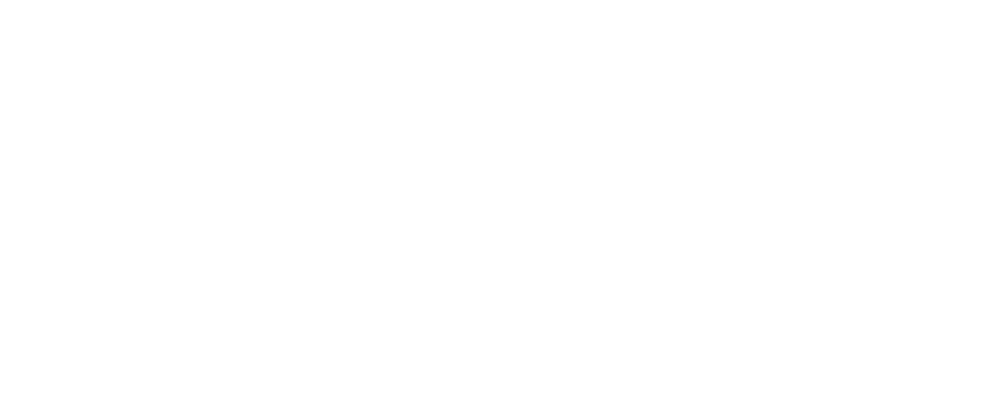

In [25]:
# display the products smiles strings with their molecule structures
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
# contain invalid molecules from the prediction result

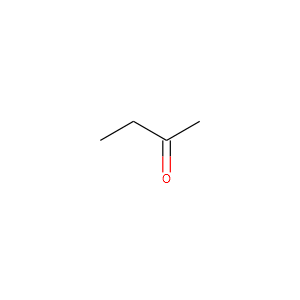

In [26]:
# the molecule structure of reactant
mol = Chem.MolFromSmiles('CCC(=O)C')
Draw.MolToImage(mol)

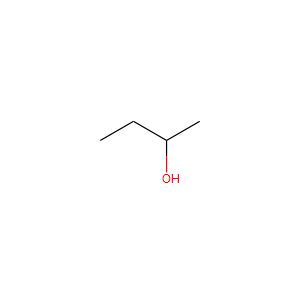

In [30]:
# the actual molecule structure of product
mol = Chem.MolFromSmiles('CCC(O)C')
Draw.MolToImage(mol)

In [28]:
#C=CC=C.Cc1ccc(C)cc1 	C=CC(C)Cc1ccc(C)cc1 # a little better
#"C=CC=O.CC(CO)CO 	C=CC1OCC(C)CO1" #bad
#CC(=O)c1ccccc1 to CCC(=O)c1ccccc1 #bad
#c1ccc(C2CO2)cc1	CC(O)c1ccccc1 # good
#O=C(O)Cc1ccccc1	O=C(O)CC1CCCCC1 # perfect
